# Libraries

In [1]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from dython.nominal import identify_numeric_columns,identify_nominal_columns,associations
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.ensemble import RandomForestClassifier

from joblib import dump

import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)

# Data

Import the dataset and do a little bit of cleansing

In [2]:
data = pd.read_csv("bank-additional-full.csv",sep=";")
data.replace("unknown",np.nan,inplace=True)
data.dropna(inplace=True)
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Show information of the dataset

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30488 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             30488 non-null  int64  
 1   job             30488 non-null  object 
 2   marital         30488 non-null  object 
 3   education       30488 non-null  object 
 4   default         30488 non-null  object 
 5   housing         30488 non-null  object 
 6   loan            30488 non-null  object 
 7   contact         30488 non-null  object 
 8   month           30488 non-null  object 
 9   day_of_week     30488 non-null  object 
 10  duration        30488 non-null  int64  
 11  campaign        30488 non-null  int64  
 12  pdays           30488 non-null  int64  
 13  previous        30488 non-null  int64  
 14  poutcome        30488 non-null  object 
 15  emp.var.rate    30488 non-null  float64
 16  cons.price.idx  30488 non-null  float64
 17  cons.conf.idx   30488 non-null 

Calculate correlation of all numerical and categorical variables using *Dython* library

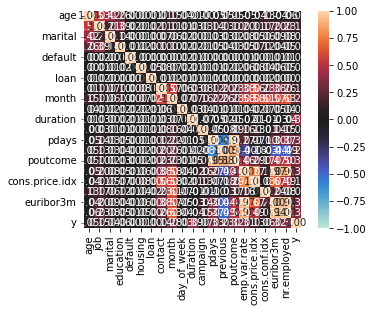

,y
duration,0.393530
nr.employed,0.364230
pdays,0.327509
poutcome,0.322919
euribor3m,0.315869
emp.var.rate,0.305365
month,0.277624
previous,0.228003
job,0.153701
contact,0.143642


In [4]:
correlation = associations(data)

data_correlation = correlation["corr"].iloc[:-1][["y"]].sort_values(by="y",ascending=False)
data_correlation.style.background_gradient(cmap="RdYlGn",axis=None)

According to various sources, correlation coefficient that's less than or equal to 2 is considered as very weak, so it's best to drop variables who have very weak correlation

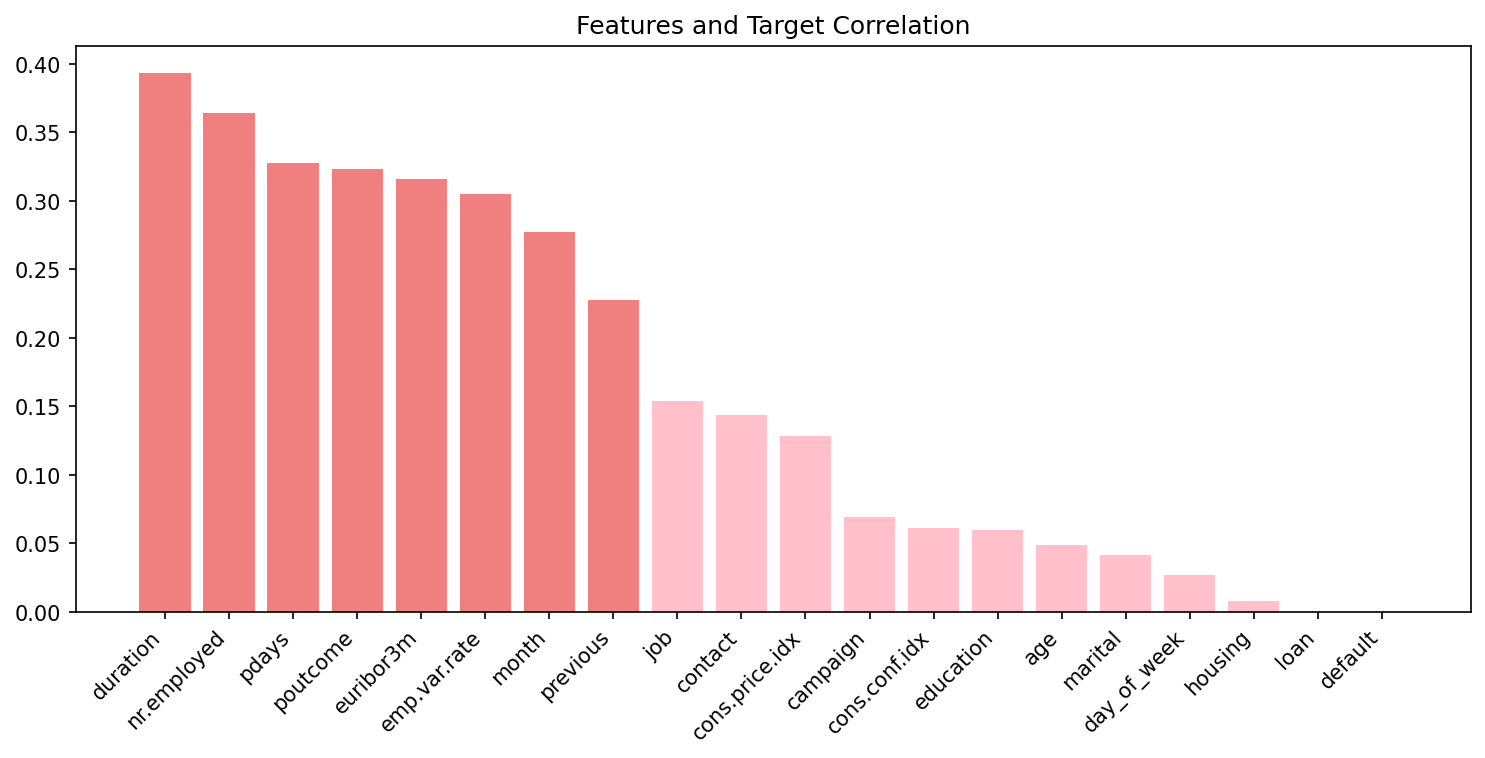

In [5]:
color = []
for _ in data_correlation.y:
    if _ >= 0.2:
        color.append("lightcoral")
    else:
        color.append("pink")

plt.figure(figsize=(12,5),dpi=150)
plt.bar(data_correlation.index,data_correlation.y,color=color)
plt.title("Features and Target Correlation")
plt.xticks(rotation=45,ha="right")
plt.ylabel("")
plt.show()

In [6]:
data = data.drop(data[(data_correlation[data_correlation["y"] < 0.2].index).tolist()],axis=1)
data.head()

,month,duration,pdays,previous,poutcome,emp.var.rate,euribor3m,nr.employed,y
0,may,261,999,0,nonexistent,1.1,4.857,5191.0,no
2,may,226,999,0,nonexistent,1.1,4.857,5191.0,no
3,may,151,999,0,nonexistent,1.1,4.857,5191.0,no
4,may,307,999,0,nonexistent,1.1,4.857,5191.0,no
6,may,139,999,0,nonexistent,1.1,4.857,5191.0,no


Create X and y variables

In [7]:
LE = LabelEncoder()
X = data.drop("y",axis=1).copy().apply(LE.fit_transform)
y = data["y"].copy()

Split the dataset into 2 sets, which are training and testing sets

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=8)

Data scalling on independent variables

In [9]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Logistic Regression

Create and train the logistic regression model

In [10]:
logistic_model = LogisticRegression(class_weight="balanced", random_state=8).fit(scaled_X_train,y_train)
logistic_model

LogisticRegression(class_weight='balanced', random_state=8)

Use the logistic regression to predict the testing set

In [11]:
logistic_prediction = logistic_model.predict(scaled_X_test)

Prediction result of the logistic regression model

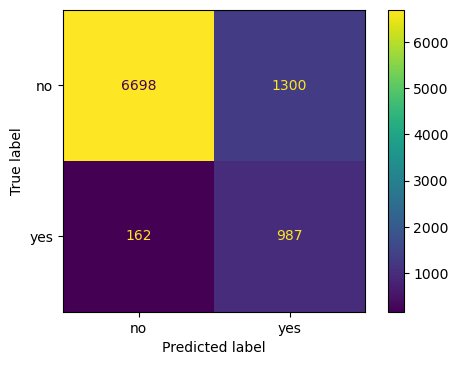

In [12]:
plt.figure(dpi=100)
plot_confusion_matrix(logistic_model, scaled_X_test, y_test, ax=plt.gca())
plt.grid(False)
plt.show()

Accuracy score of the logistic regression model

In [13]:
print("Accuracy = " + str(np.round(accuracy_score(y_test, logistic_prediction)*100,3)) + "%")

Accuracy = 84.017%


Retrain with the whole dataset to create the final logistic regression model

In [14]:
final_logistic_model = LogisticRegression(class_weight="balanced", random_state=8, max_iter=10_000).fit(X,y)
final_logistic_model

LogisticRegression(class_weight='balanced', max_iter=10000, random_state=8)

Logistic regression's beta coefficients

In [15]:
pd.DataFrame({
    "Variables":["Constant"] + X.columns.tolist(),
    "Beta Coefficients":[final_logistic_model.intercept_[0]] + final_logistic_model.coef_[0].tolist()
}).set_index("Variables")

,Beta Coefficients
Variables,
Constant,2.440869
month,-0.127650
duration,0.006553
pdays,-0.051095
previous,-0.032586
poutcome,0.543622
emp.var.rate,-0.210862
euribor3m,-0.002231
nr.employed,-0.290690


Logistic regression equation where $ \log(\frac{\pi(x)}{1 - \pi(x}) = \beta_0 + \beta_1X_1 + \beta_2X_2 + ... + \beta_nX_n$

In [16]:
x = sp.Symbol("(x)")
beta = []
for _ in X.columns:
    beta.append(sp.Symbol(f"({_})"))
    
total = np.round(final_logistic_model.intercept_[0],3)
for _ in range(len(X.columns)):
    total = total + (beta[_] * np.round(final_logistic_model.coef_[0,_],3))
    
sp.Eq(sp.log((sp.pi*x) / (1 - (sp.pi*x))),total)

Eq(log(pi*(x)/(-pi*(x) + 1)), 0.007*(duration) - 0.211*(emp.var.rate) - 0.002*(euribor3m) - 0.128*(month) - 0.291*(nr.employed) - 0.051*(pdays) + 0.544*(poutcome) - 0.033*(previous) + 2.441)

# K-Nearest Neighbors

Calculate and visualize the error rates for 25 K values

In [17]:
errors = []
for _ in range(1,26):
    temp_model = KNeighborsClassifier(n_neighbors=_)
    temp_model.fit(scaled_X_train,y_train)
    temp_pred = temp_model.predict(scaled_X_test)
    error = 100 - (accuracy_score(y_test,temp_pred)*100)
    errors.append(error)

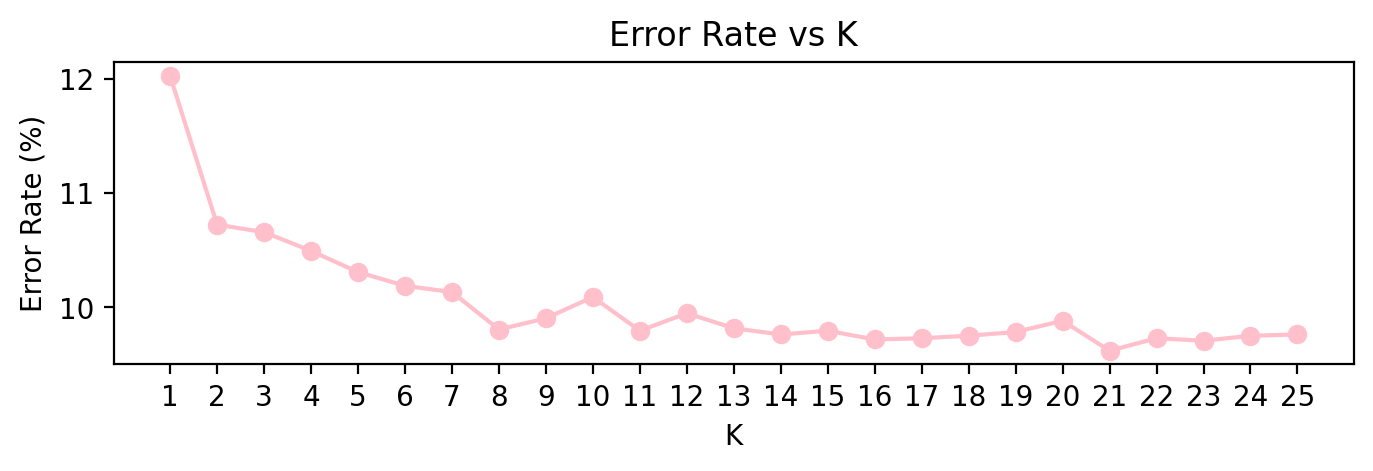

In [18]:
plt.figure(figsize=(8,2),dpi=200)
plt.plot(range(1,26),errors,color="pink",marker="o")
plt.title("Error Rate vs K")
plt.xlabel("K")
plt.xticks(range(1,26))
plt.ylabel("Error Rate (%)")
plt.show()

Create and train the k-nearest neighbors model with k = 5

In [19]:
knearest_model = KNeighborsClassifier(n_neighbors=5,weights="distance").fit(scaled_X_train,y_train)
knearest_model

KNeighborsClassifier(weights='distance')

Use the k-nearest neighbors to predict the testing set

In [20]:
knearest_prediction = knearest_model.predict(scaled_X_test)

Prediction result of the k-nearest neighbors model

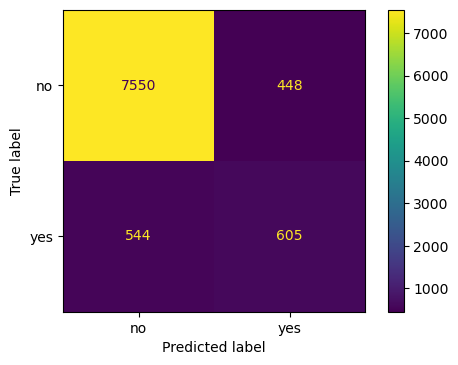

In [21]:
plt.figure(dpi=100)
plot_confusion_matrix(knearest_model, scaled_X_test, y_test, ax=plt.gca())
plt.grid(False)
plt.show()

Accuracy score of the k-nearest neighbors model

In [22]:
print("Accuracy = " + str(np.round(accuracy_score(y_test, knearest_prediction)*100,3)) + "%")

Accuracy = 89.155%


Retrain with the whole dataset to create the final k-nearest neighbors model

In [23]:
final_knn_model = KNeighborsClassifier(n_neighbors=5,weights="distance").fit(X,y)
final_knn_model

KNeighborsClassifier(weights='distance')

# Support Vector Machine

Create and train the support vector machine model

In [24]:
support_model = SVC(class_weight="balanced",random_state=8).fit(scaled_X_train,y_train)
support_model

SVC(class_weight='balanced', random_state=8)

Use the support vector machine to predict the testing set

In [25]:
support_prediction = support_model.predict(scaled_X_test)

Prediction result of the support vector machine model

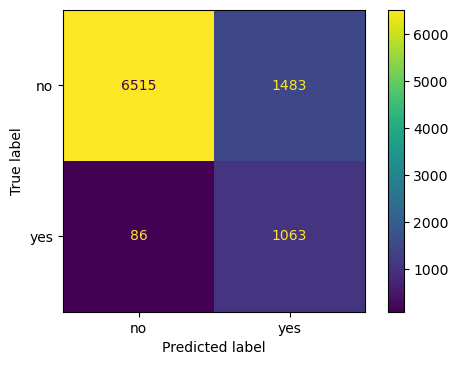

In [26]:
plt.figure(dpi=100)
plot_confusion_matrix(support_model, scaled_X_test, y_test, ax=plt.gca())
plt.grid(False)
plt.show()

Accuracy score of the support vector machine model

In [27]:
print("Accuracy = " + str(np.round(accuracy_score(y_test, support_prediction)*100,3)) + "%")

Accuracy = 82.847%


Retrain with the whole dataset to create the final support vector machine model

In [28]:
final_support_model = SVC(class_weight="balanced",random_state=42).fit(X,y)
final_support_model

SVC(class_weight='balanced', random_state=42)

# Decision Tree

Create and train the decision tree model

In [29]:
decision_model = DecisionTreeClassifier(max_depth=6,class_weight="balanced",random_state=8).fit(scaled_X_train,y_train)
decision_model

DecisionTreeClassifier(class_weight='balanced', max_depth=6, random_state=8)

Use the decision tree to predict the testing set

In [30]:
decision_prediction = decision_model.predict(scaled_X_test)

Prediction result of the decision tree model

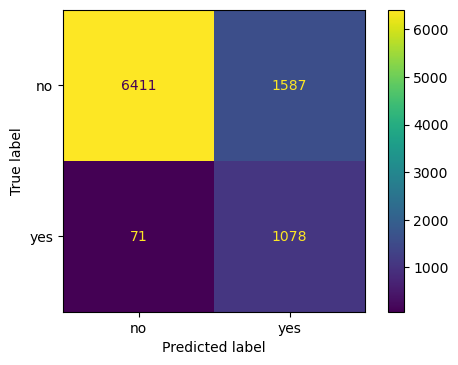

In [31]:
plt.figure(dpi=100)
plot_confusion_matrix(decision_model, scaled_X_test, y_test, ax=plt.gca())
plt.grid(False)
plt.show()

Accuracy score of the decision tree model

In [32]:
print("Accuracy = " + str(np.round(accuracy_score(y_test, decision_prediction)*100,3)) + "%")

Accuracy = 81.874%


Decision tree model's feature importance

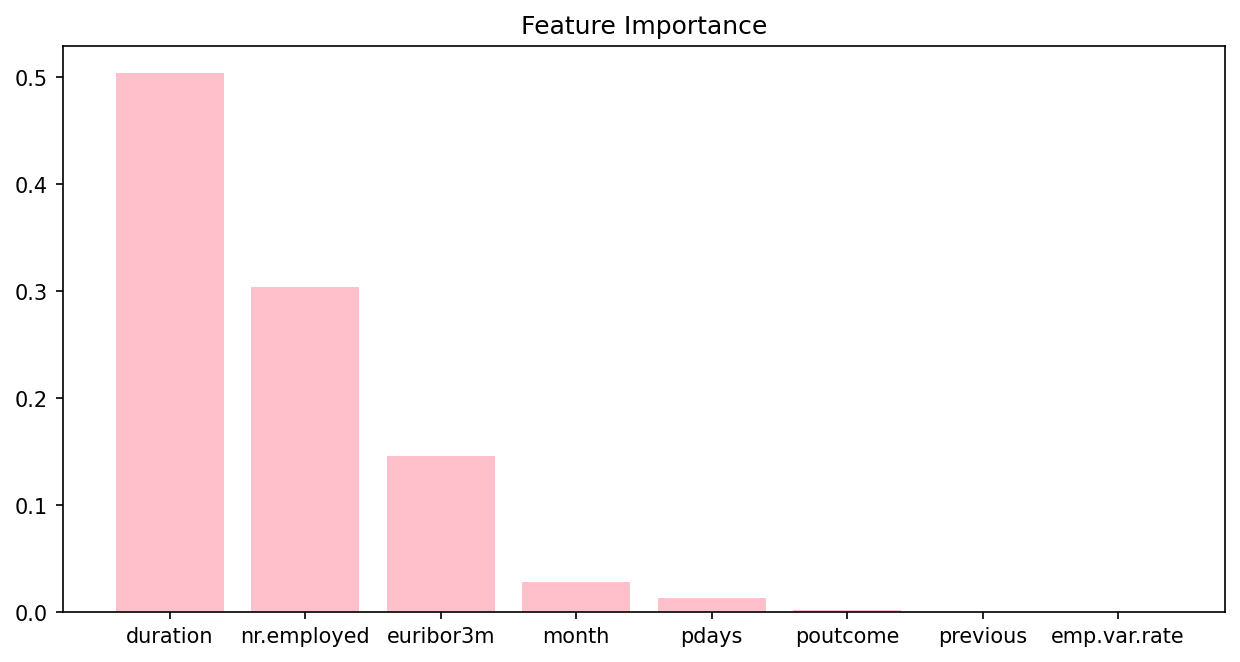

In [33]:
decision_feature = pd.DataFrame(
    data=decision_model.feature_importances_, index=X.columns, columns=["Feature Importance"]
).sort_values("Feature Importance", ascending=False)

fig = plt.figure(figsize=(10,5),dpi=150)
plt.bar(decision_feature.index,decision_feature["Feature Importance"],color="pink")
plt.title("Feature Importance")
plt.show()

Retrain with the whole dataset to create the final decision tree model

In [34]:
final_decision_model = DecisionTreeClassifier(max_depth=5, class_weight="balanced", random_state=8).fit(X,y)
final_decision_model

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=8)

Visualize the decision tree model

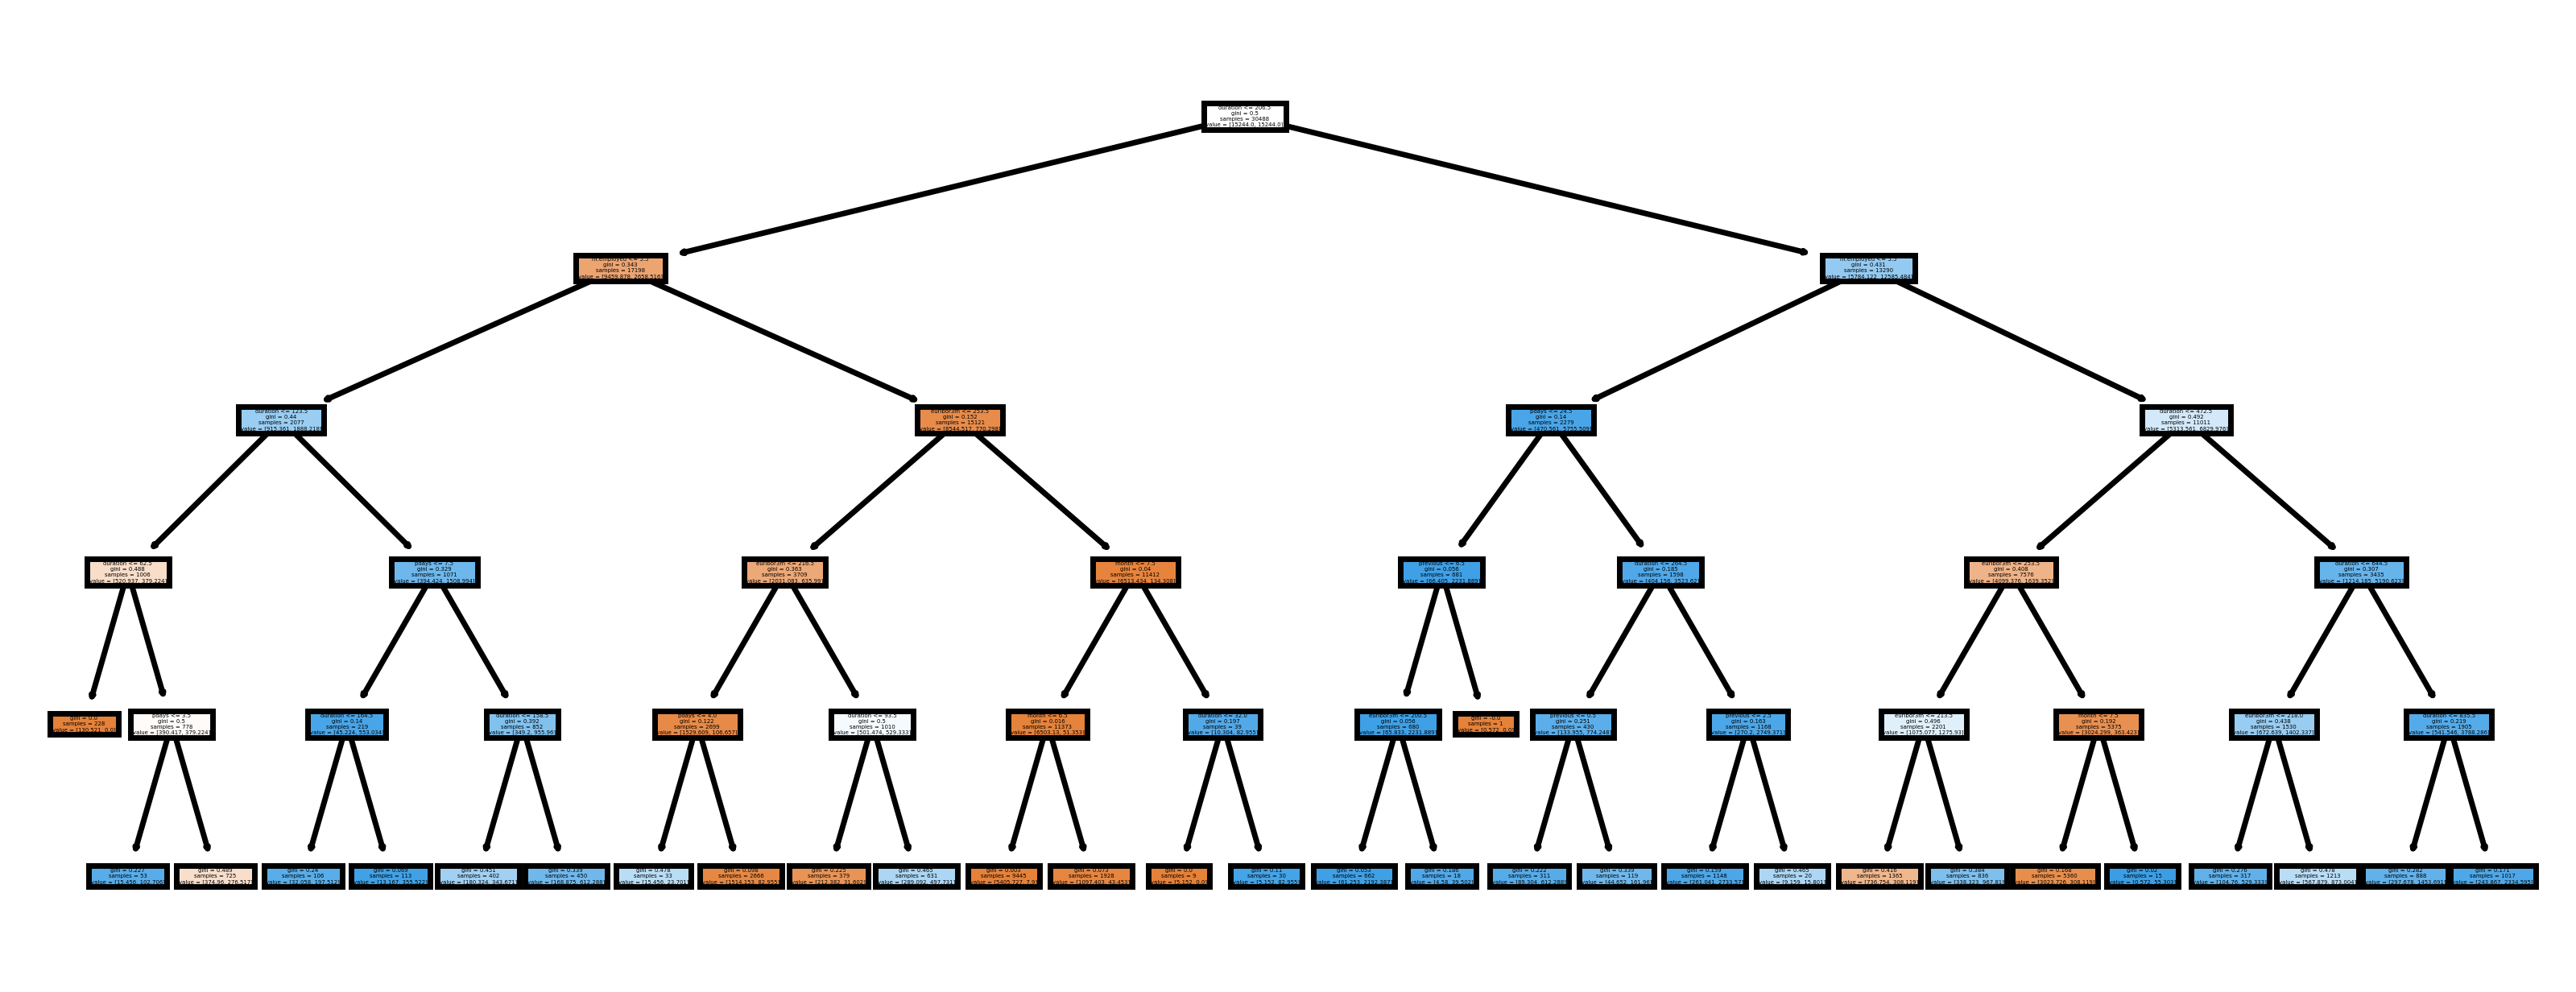

In [35]:
plt.figure(figsize=(8,3),dpi=500)
plot_tree(final_decision_model, filled=True, feature_names=X.columns)
plt.show()

# Random Forest

Calculate and visualize the error rates for 25 numbers of trees

In [36]:
errors = []
for _ in range(1,26):
    temp_model = RandomForestClassifier(n_estimators=_, class_weight="balanced", random_state=8)
    temp_model.fit(scaled_X_train,y_train)
    temp_pred = temp_model.predict(scaled_X_test)
    error = 100 - (accuracy_score(y_test,temp_pred)*100)
    errors.append(error)

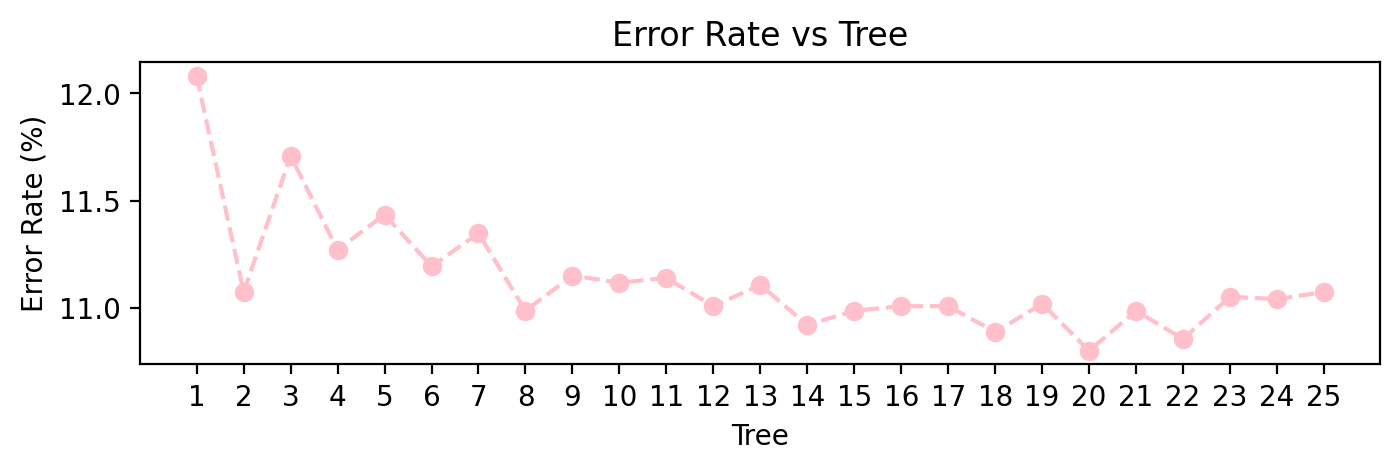

In [37]:
plt.figure(figsize=(8,2),dpi=200)
plt.plot(range(1,26),errors,color="pink",marker="o",ls="--")
plt.title("Error Rate vs Tree")
plt.xlabel("Tree")
plt.xticks(range(1,26))
plt.ylabel("Error Rate (%)")
plt.show()

Create and train the random forest model with 6 trees

In [38]:
random_model = RandomForestClassifier(n_estimators=6, class_weight="balanced", random_state=8).fit(scaled_X_train,y_train)
random_model

RandomForestClassifier(class_weight='balanced', n_estimators=6, random_state=8)

Use the random forest to predict the testing set

In [39]:
random_prediction = random_model.predict(scaled_X_test)

Prediction result of the random forest model

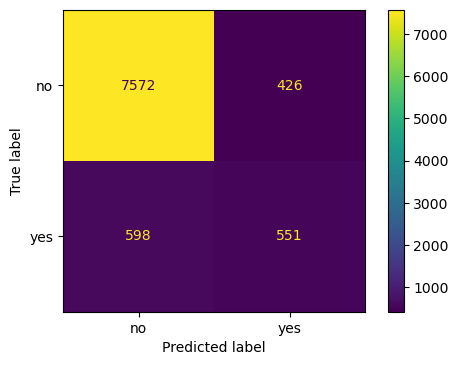

In [40]:
plt.figure(dpi=100)
plot_confusion_matrix(random_model, scaled_X_test, y_test, ax=plt.gca())
plt.grid(False)
plt.show()

Accuracy score of the random forest model

In [41]:
print("Accuracy = " + str(np.round(accuracy_score(y_test, random_prediction)*100,3)) + "%")

Accuracy = 88.805%


Random forest model's feature importance

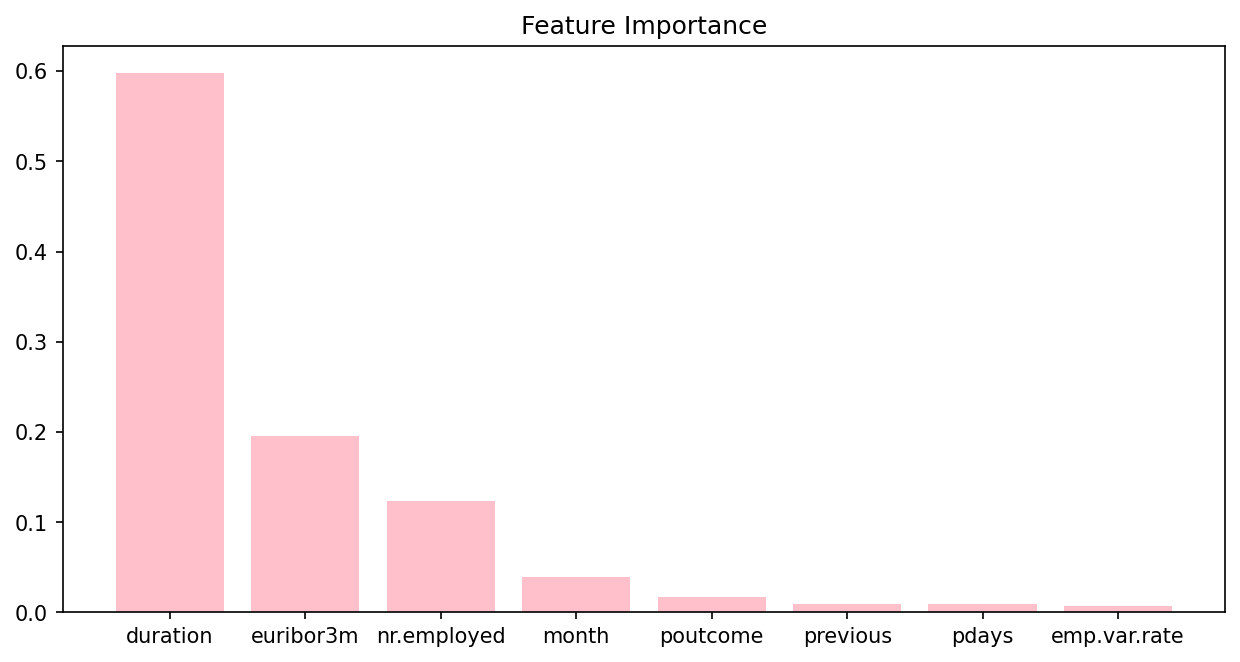

In [42]:
random_feature = pd.DataFrame(
    data=random_model.feature_importances_, index=X.columns, columns=["Feature Importance"]
).sort_values("Feature Importance", ascending=False)

fig = plt.figure(figsize=(10,5),dpi=150)
plt.bar(random_feature.index,random_feature["Feature Importance"],color="pink")
plt.title("Feature Importance")
plt.show()

Retrain with the whole dataset to create the final random forest model

In [43]:
final_random_model = RandomForestClassifier(n_estimators=6, class_weight="balanced", random_state=8).fit(X,y)
final_random_model

RandomForestClassifier(class_weight='balanced', n_estimators=6, random_state=8)

# Naive Bayes

Create and train the naive bayes model

In [44]:
naive_model = BernoulliNB().fit(scaled_X_train,y_train)
naive_model

BernoulliNB()

Use the naive bayes to predict the testing set

In [45]:
naive_prediction = naive_model.predict(scaled_X_test)

Prediction result of the naive bayes model

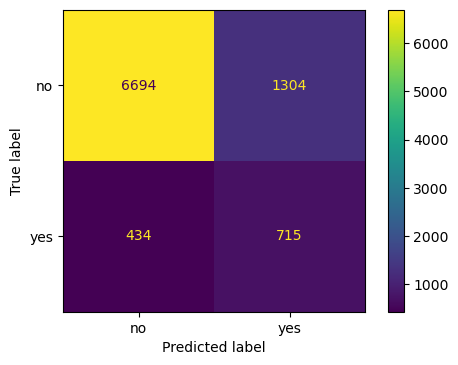

In [46]:
plt.figure(dpi=100)
plot_confusion_matrix(naive_model, scaled_X_test, y_test, ax=plt.gca())
plt.grid(False)
plt.show()

Accuracy score of the naive bayes model

In [47]:
print("Accuracy = " + str(np.round(accuracy_score(y_test, naive_prediction)*100,3)) + "%")

Accuracy = 80.999%


Retrain with the whole dataset to create the final naive bayes model

In [48]:
final_naive_model = BernoulliNB().fit(X,y)
final_naive_model

BernoulliNB()

# Conclusion

Based on the analysis above, it's known that k-nearest neighbors and random forest models have high accuracy scores (almost 90%). However, those two models' predictions are inaccurate and imbalanced, so they aren't recommended. For the rest of the models, the logistic regression model have the highest accuracy score of around 84% and thus it's the best model to be used in this case.

In [49]:
print("Accuracy Score for Each Model")
print(f"Logistic Regression\t: {np.round(accuracy_score(y_test,logistic_prediction)*100,3)}%")
print(f"Support Vector Machine\t: {np.round(accuracy_score(y_test,support_prediction)*100,3)}%")
print(f"Decision Tree\t\t: {np.round(accuracy_score(y_test,decision_prediction)*100,3)}%")
print(f"Naive Bayes\t\t: {np.round(accuracy_score(y_test,naive_prediction)*100,3)}%")

Accuracy Score for Each Model
Logistic Regression	: 84.017%
Support Vector Machine	: 82.847%
Decision Tree		: 81.874%
Naive Bayes		: 80.999%


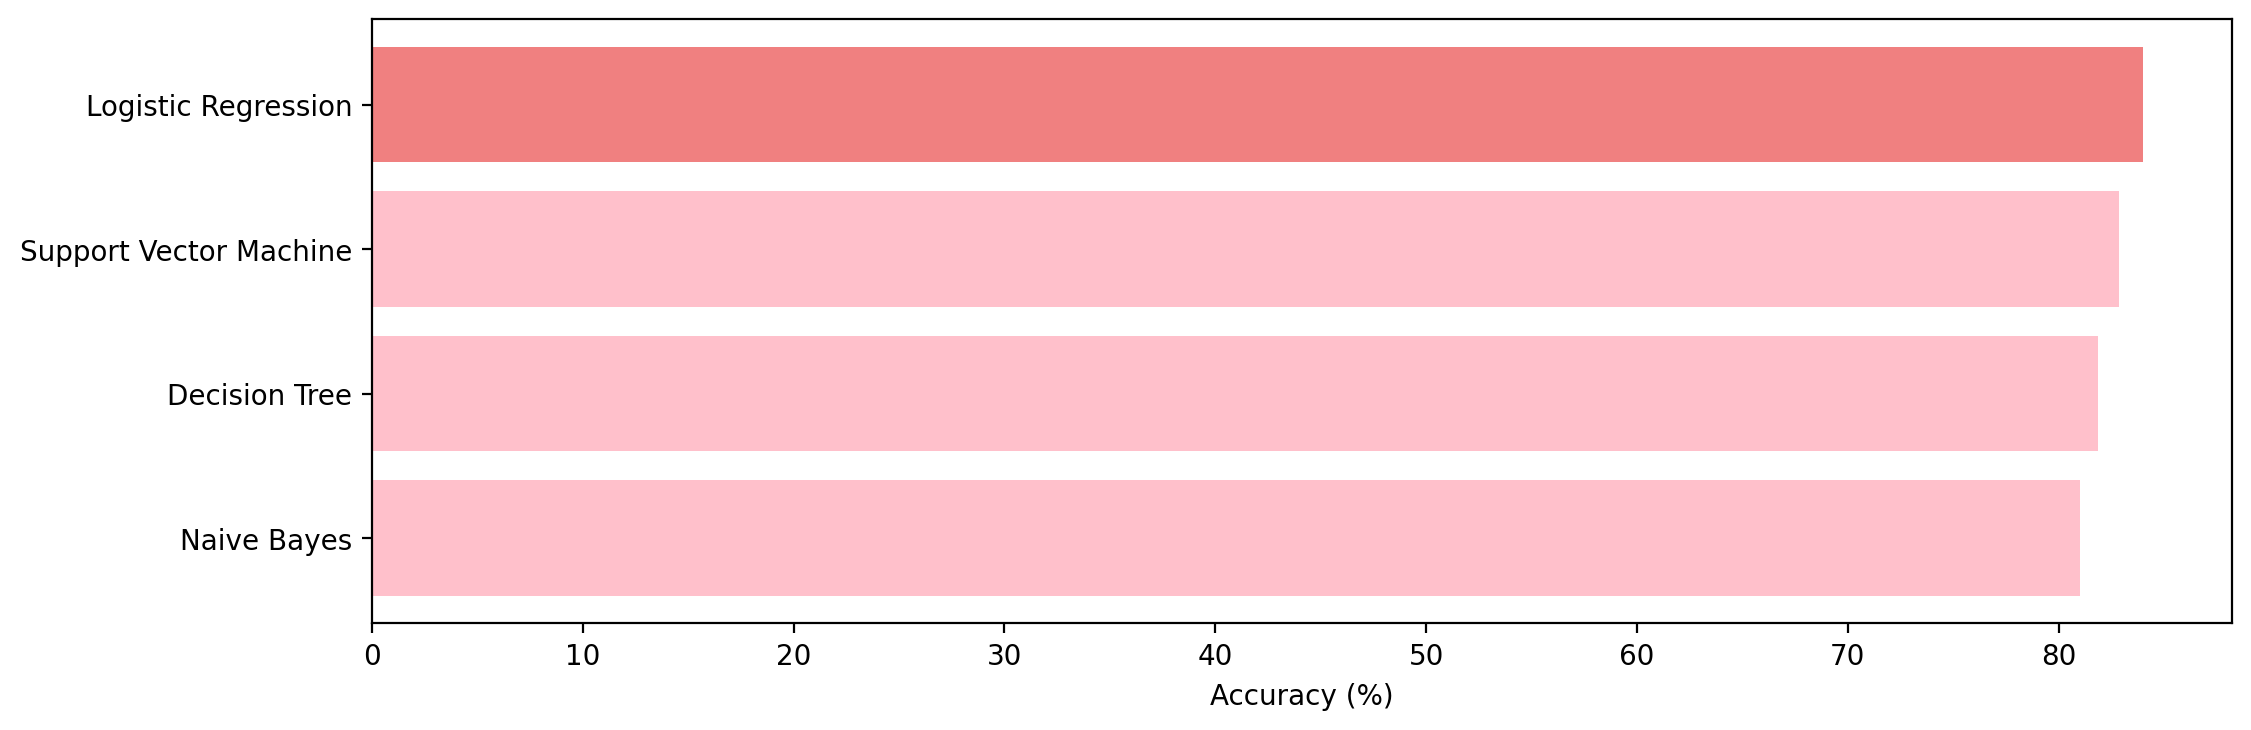

In [50]:
x = ["Naive Bayes","Decision Tree","Support Vector Machine","Logistic Regression"]
y = [np.round(accuracy_score(y_test,naive_prediction)*100,3),np.round(accuracy_score(y_test,decision_prediction)*100,3),
     np.round(accuracy_score(y_test,support_prediction)*100,3),np.round(accuracy_score(y_test,logistic_prediction)*100,3)]

color = []
for _ in np.array(y):
    if _ == np.max(np.array(y)):
        color.append("lightcoral")
    else:
        color.append("pink")

plt.figure(figsize=(12,4),dpi=200)
plt.barh(x,y,color=color)
plt.xlabel("Accuracy (%)")
plt.show()

Comparison between the actual value and predictions

In [51]:
pd.DataFrame({
    "actual":y_test,
    "logistic_regression":logistic_prediction,
    "support_vector_machine":support_prediction,
    "decision_tree":decision_prediction,
    "random_forest":random_prediction
}).reset_index(drop=True)

,actual,logistic_regression,support_vector_machine,decision_tree,random_forest
0,no,no,no,no,no
1,no,no,no,no,no
2,no,no,yes,yes,yes
3,no,yes,yes,yes,yes
4,no,yes,yes,yes,no
...,...,...,...,...,...
9142,no,no,no,no,no
9143,no,no,no,no,no
9144,yes,yes,yes,yes,yes
9145,no,no,no,no,no


Download all final models to be used in the future

In [52]:
num = 0
for m,n in zip(
    ["Naive Bayes.joblib","Decision Tree.joblib","Support Vector Machine.joblib","Logistic Regression.joblib"],
    [naive_model,decision_model,support_model,logistic_model]
):
    dump(n,m)
    num += 1
    
if num == 4:
    print("All models have been downloaded")

All models have been downloaded
